In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32873")
client

<Client: 'tcp://127.0.0.1:32873' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:36609' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
import gsw
import time
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'
spec = '/tank/spectre/tuchida/NA-wavelets/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xchunk = 100
ychunk = 100
dCs = 1e-5
# iiter = 1419120
# Cs = xr.open_dataset(op.join(savedir,"Max-sound-speed_%010d.nc" % iiter)).Cs
Cs = xr.open_dataset(op.join(savedir,"Max-snap-sound-speed_1967.nc")).Cs
Cs

<xarray.DataArray 'Cs' (Z: 46)>
[46 values with dtype=float32]
Coordinates:
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 ...
    PHrefC   (Z) float32 ...
    rhoRef   (Z) float32 ...
    iter     int64 ...
    time     timedelta64[ns] ...

In [ ]:
nmembs = np.arange(100,148)

for iiter in ntimes[0,:3]:
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(yNstart-12**-1,yend+2*12**-1),
                                      # YG=slice(yNstart-12**-1,yend+2*12**-1)
                                     ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                           'YC':ychunk,'YG':ychunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(
                                                     # YC=slice(yNstart-12**-1,yend+2*12**-1),
                                                     # YG=slice(yNstart-12**-1,yend+2*12**-1)
                                                    ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                                          'YC':ychunk,'YG':ychunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    # ds = ds.chunk({'nmemb':6})      
    v = ds.VVEL
    u = ds.UVEL
    theta = ds.THETA.where(ds.maskC!=0.)
    salt = ds.SALT.where(ds.maskC!=0.)

    grid = Grid(ds, periodic=['X'])
    rho_til = grid.interp(rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF.load(), 'Z',
                                                            boundary='extend')
                                              )),
                          'Z', boundary='extend'
                         )
    pres = rhoConst*grav*(-ds.Z) * 1e-4
    rho = xr.apply_ufunc(densjmd95, salt, theta, 
                         pres, 
                         dask='parallelized', output_dtypes=[float,]
                        )
    b = -(rho - rho_til) / rhoConst
    
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).isel(time=0)

    wp = grid.interp(ds.WVEL-dsb.WVEL,'Z',boundary='extend').where(ds.maskC!=0.)
    bp = b - b.mean('nmemb',skipna=True)
    
    zeta = grid.interp(grid.interp((grid.diff(v*ds.dyC,'X')
                                    - grid.diff(u*ds.dxC,'Y',boundary='extend')
                                   ) / ds.rAz,'X'
                                  ),'Y',boundary='extend'
                      ).where(ds.maskC!=0.)
    # w_x = grid.diff(w*grid.interp(ds.dyC,'Y',boundary='extend'),'X') / ds.rAw
    # w_y = grid.diff(w*grid.interp(ds.dxC,'X'),'Y',boundary='extend') / ds.rAs
    b_z = grid.interp(-grid.diff(b,'Z',boundary='extend') 
                      / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                      'Z',boundary='extend'
                     )
    b_y = grid.interp(grid.diff(b,'Y',boundary='extend') 
                      / ds.dyC,'Y',boundary='extend'
                     )
    b_x = grid.interp(grid.diff(b,'X') 
                      / ds.dxC,'X'
                     )
    v_z = grid.interp(-grid.diff(v,'Z',boundary='extend') 
                      / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                      'Z',boundary='extend'
                     )
    u_z = grid.interp(-grid.diff(u,'Z',boundary='extend') 
                      / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                      'Z',boundary='extend'
                     )
    f = xr.apply_ufunc(gsw.f, ds.YC)

    PVv = ((zeta+f) 
           * b_z
          ).reset_coords(drop=True).chunk({'nmemb':1,'Z':-1,'XC':xchunk,'YC':ychunk})
    PVh = (-grid.interp(v_z,'Y',boundary='extend')*b_x 
           + grid.interp(u_z,'X')*b_y
          ).reset_coords(drop=True).chunk({'nmemb':1,'Z':-1,'XC':xchunk,'YC':ychunk})
    print(PVv, PVh)

    PVvb = PVv.mean('nmemb',skipna=True).compute().chunk({'XC':xchunk,'YC':ychunk})
    PVhb = PVh.mean('nmemb',skipna=True).compute().chunk({'XC':xchunk,'YC':ychunk})
    
    PVvp = PVv - PVvb
    PVhp = PVh - PVhb

    dsave = PVvp.to_dataset(name='pEPVv')
    dsave['pEPVh'] = PVhp
    dsave['bEPVv'] = PVvb
    dsave['bEPVh'] = PVhb
    dsave.pEPVv.encoding = {}
    dsave.pEPVh.encoding = {}
    dsave.bEPVv.encoding = {}
    dsave.bEPVh.encoding = {}
    dsave.chunk({'nmemb':4,'Z':1,'YC':xchunk,'XC':ychunk}
               ).to_zarr(op.join(savedir,'SnapErtelPV/%2dmembers/%010d_1967.zarr'
                         % (len(nmembs),iiter)), mode='w'
                        )

    dsave.close()
    ds.close()

In [11]:
nmembs = np.arange(100,148)

for iiter in ntimes[0,:1]:
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(yNstart-12**-1,yend+2*12**-1),
                                      # YG=slice(yNstart-12**-1,yend+2*12**-1)
                                     ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                           'YC':ychunk,'YG':ychunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(
                                                     # YC=slice(yNstart-12**-1,yend+2*12**-1),
                                                     # YG=slice(yNstart-12**-1,yend+2*12**-1)
                                                    ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                                          'YC':ychunk,'YG':ychunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    # ds = ds.chunk({'nmemb':6})      
    v = ds.VVEL
    u = ds.UVEL
    
    grid = Grid(ds, periodic=['X'])
    
    zeta = grid.interp(grid.interp((grid.diff(v*ds.dyC,'X')
                                    - grid.diff(u*ds.dxC,'Y',boundary='extend')
                                   ) / ds.rAz,'X'
                                  ),'Y',boundary='extend'
                      ).where(ds.maskC!=0.).reset_coords(drop=True)

    zetab = zeta.mean('nmemb',skipna=True).compute().chunk({'XC':xchunk,'YC':ychunk})
    
    zetap = zeta - zetab

    dsave = zetap.to_dataset(name='zetap')
    dsave['zetab'] = zetab
    dsave.zetap.encoding = {}
    dsave.zetab.encoding = {}
    dsave.chunk({'nmemb':4,'Z':1,'YC':xchunk,'XC':ychunk}
               ).to_zarr(op.join(spec,'SnapZeta/%2dmembers/%010d_1967.zarr'
                         % (len(nmembs),iiter)), mode='w'
                        )

    dsave.close()
    ds.close()

In [16]:
# dsq = xr.open_zarr(op.join(savedir,'SnapErtelPV/48members/15N-50N_%010d.zarr'
#                           % (1419120))
#                  ).sel(YC=slice(yNstart-12**-1,yend+12**-1))
dsq = xr.open_zarr(op.join(spec,'SnapZeta/48members/%010d_1967.zarr'
                          % (1421280))
                 ).sel(YC=slice(yNstart-12**-1,yend+12**-1))
f = f = xr.apply_ufunc(gsw.f, dsq.YC)
dsq

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 422, Z: 46, nmemb: 48)
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 14.92 15.0 15.08 15.17 ... 49.75 49.83 49.92 50.0
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    zetab    (Z, YC, XC) float32 dask.array<chunksize=(1, 82, 100), meta=np.ndarray>
    zetap    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(4, 1, 82, 100), meta=np.ndarray>

In [17]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

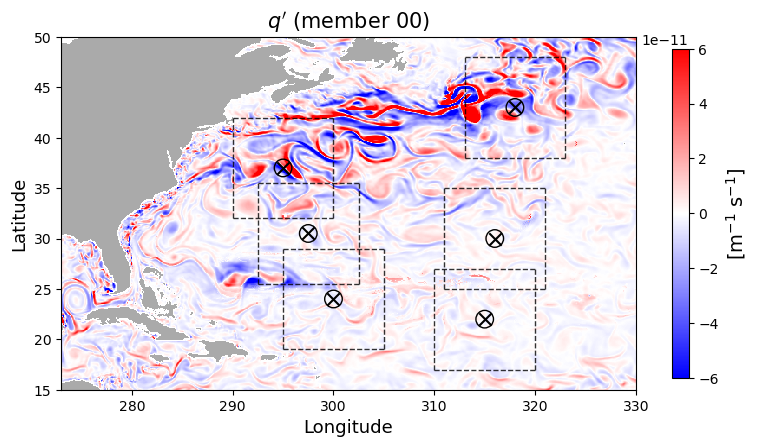

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,50+12**-1)),
                   (dsq.pEPVh + dsq.pEPVv).isel(nmemb=0,Z=0).sel(XC=slice(273,330),
                                                                 YC=slice(15,50+12**-1)
                                                                ), 
                   vmax=6e-11, vmin=-6e-11, cmap='bwr', rasterized=True
                  )
for reg in range(6):
    ax.plot(np.ones(10)*(xs[reg]-5), np.linspace(ys[reg]-5,ys[reg]+5,10),
            'k--', lw=1, alpha=.8)
    ax.plot(np.ones(10)*(xs[reg]+5), np.linspace(ys[reg]-5,ys[reg]+5,10),
            'k--', lw=1, alpha=.8)
    ax.plot(np.linspace(xs[reg]-5,xs[reg]+5,10), np.ones(10)*(ys[reg]+5),
            'k--', lw=1, alpha=.8)
    ax.plot(np.linspace(xs[reg]-5,xs[reg]+5,10), np.ones(10)*(ys[reg]-5),
            'k--', lw=1, alpha=.8)
ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,50+12**-1)),
              ds.maskInC.where(ds.maskInC!=1.).sel(XC=slice(273,330),
                                                   YC=slice(15,50+12**-1)),
              vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax.scatter(xs, ys, marker='x', s=80, c='k')
ax.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='k')

ax.set_ylim([yNstart,yend])
ax.set_xlabel(r"Longitude", fontsize=13)
ax.set_ylabel(r"Latitude", fontsize=13)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{-1}$ s$^{-1}$]", fontsize=14)
ax.set_title(r"$q'$ (member 00)", fontsize=15)

ax.set_aspect('equal')

plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/SnapEPVp_member00.pdf'))

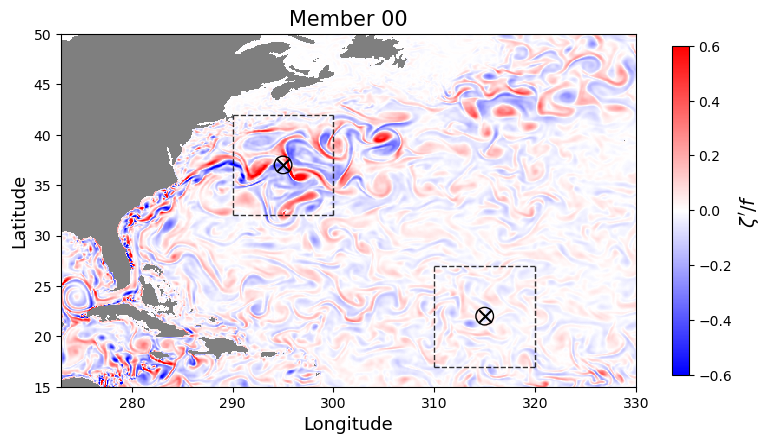

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,50+12**-1)),
                   (dsq.zetap/f).isel(nmemb=0,Z=0).sel(XC=slice(273,330),
                                                                 YC=slice(15,50+12**-1)
                                                                ), 
                   vmax=.6, vmin=-.6, cmap='bwr', rasterized=True
                  )
for reg in range(6):
    if reg == 0 or reg == 5:
        ax.plot(np.ones(10)*(xs[reg]-5), np.linspace(ys[reg]-5,ys[reg]+5,10),
                'k--', lw=1, alpha=.8)
        ax.plot(np.ones(10)*(xs[reg]+5), np.linspace(ys[reg]-5,ys[reg]+5,10),
                'k--', lw=1, alpha=.8)
        ax.plot(np.linspace(xs[reg]-5,xs[reg]+5,10), np.ones(10)*(ys[reg]+5),
                'k--', lw=1, alpha=.8)
        ax.plot(np.linspace(xs[reg]-5,xs[reg]+5,10), np.ones(10)*(ys[reg]-5),
                'k--', lw=1, alpha=.8)
        
        ax.scatter(xs[reg], ys[reg], marker='x', s=80, c='k')
        ax.scatter(xs[reg], ys[reg], marker='o', s=160, facecolors='none', edgecolors='k')
        
ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,50+12**-1)),
              ds.maskInC.where(ds.maskInC!=1.).sel(XC=slice(273,330),
                                                   YC=slice(15,50+12**-1)),
              vmin=-1.5, vmax=1.5, cmap='binary', rasterized=True)


ax.set_ylim([yNstart,yend])
ax.set_xlabel(r"Longitude", fontsize=13)
ax.set_ylabel(r"Latitude", fontsize=13)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"$\zeta'/f$", fontsize=14)
ax.set_title(r"Member 00", fontsize=15)

ax.set_aspect('equal')

plt.savefig(op.join(spec,'Figs/SnapRop_member00.pdf'))

Text(0.5, 1.0, "$q'$ (member 00)")

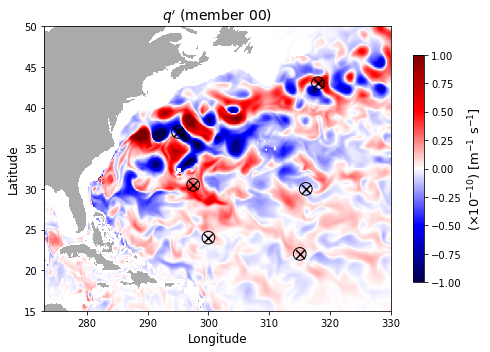

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),
                   (ds.pEPVh + ds.pEPVv).isel(nmemb=0,Z=20).sel(XC=slice(273,330),
                                                                YC=slice(15,None))*1e10, 
                   vmax=1, vmin=-1, cmap='seismic', rasterized=True
                  )
ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),
              ds.maskC.where(ds.maskC!=1.).isel(Z=20).sel(XC=slice(273,330),
                                                          YC=slice(15,50+12**-1)),
              vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax.scatter(xs, ys, marker='x', s=80, c='k')
ax.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='k')
ax.set_ylim([yNstart,yend])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"$(\times 10^{-10})$ [m$^{-1}$ s$^{-1}$]", fontsize=13)
ax.set_title(r"$q'$ (member 00)", fontsize=14)
# plt.savefig(op.join(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/SnapEPVp_member00.pdf')))

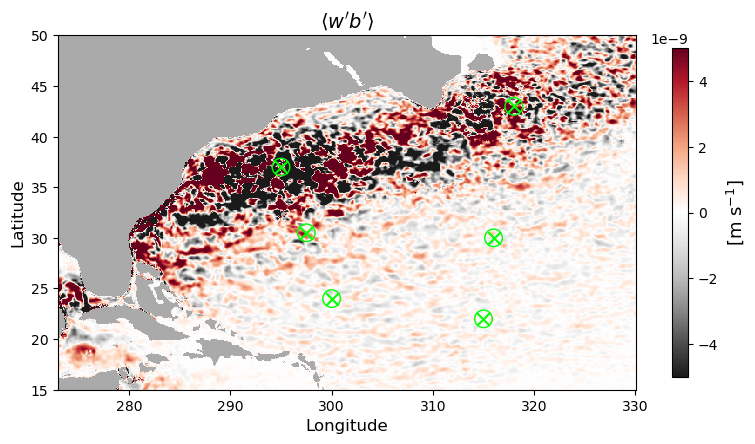

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),
                   (wp*bp).isel(Z=18).sel(XC=slice(273,330),YC=slice(15,None)
                                         ).mean('nmemb',skipna=True), 
                   vmax=5e-9, vmin=-5e-9, cmap='RdGy_r', rasterized=True
                  )
ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,50+12**-1)),
              ds.maskC.where(ds.maskC!=1.).isel(Z=18).sel(XC=slice(273,330),
                                                          YC=slice(15,50+12**-1)),
              vmin=-1, vmax=2, cmap='binary', rasterized=True
             )
ax.scatter(xs, ys, marker='x', s=80, c='lime')
ax.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime')

ax.set_ylim([yNstart,yend])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m s$^{-1}$]", fontsize=13)
ax.set_title(r"$\langle w'b'\rangle$", fontsize=14)

ax.set_aspect('equal')

plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/wpbpb_Z%04d_%010d.pdf'
                    % (ds.Z.isel(Z=18).data,iiter))
           )

In [7]:
nmembs = np.arange(100,148)

for iiter in ntimes[0,:1]:
    dsm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(yNstart-12**-1,yend+2*12**-1),
                               # YG=slice(yNstart-12**-1,yend+2*12**-1)
                              ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                    'YC':ychunk,'YG':ychunk})
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(yNstart-12**-1,yend+2*12**-1),
                                      # YG=slice(yNstart-12**-1,yend+2*12**-1)
                                     ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                           'YC':ychunk,'YG':ychunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(
                                                     # YC=slice(yNstart-12**-1,yend+2*12**-1),
                                                     # YG=slice(yNstart-12**-1,yend+2*12**-1)
                                                    ).isel(time=0).chunk({'XC':xchunk,
                                                                          'XG':xchunk,
                                                                          'YC':ychunk,
                                                                          'YG':ychunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    # ds = ds.chunk({'nmemb':6})      
    v = ds.VVEL - dsm.VVEL
    u = ds.UVEL - dsm.UVEL
    f = xr.apply_ufunc(gsw.f, ds.YG, dask='parallelized')

    grid = Grid(ds, periodic=['X'])
    
    Ro = ((grid.diff(v*ds.dyC*ds.hFacS,'X')
           - grid.diff(u*ds.dxC*ds.hFacW,'Y',boundary='extend')
          ) / ds.rAz
          / grid.interp(ds.hFacS,'X') / f
         ).where(grid.interp(ds.maskS,'X')!=0.)
    
    # ds.close()
    
Ro

<xarray.DataArray (nmemb: 48, Z: 46, YG: 900, XG: 1000)>
dask.array<where, shape=(48, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
    iter     int64 1421280
    time     timedelta64[ns] 3290 days
    rAz      (YG, XG) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [8]:
Ro_25 = Ro.chunk({'nmemb':-1}).quantile(.25, dim='nmemb'
                                       ).isel(Z=18).sel(XG=slice(273,330),
                                       YG=slice(15,None)
                                      ).compute()
Ro_75 = Ro.chunk({'nmemb':-1}).quantile(.75, dim='nmemb'
                                       ).isel(Z=18).sel(XG=slice(273,330),
                                       YG=slice(15,None)
                                      ).compute()

In [9]:
nn = 10

fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds.XG.sel(XG=slice(273,330)), ds.YG.sel(YG=slice(15,None)),
                   # (Ro).isel(Z=18).sel(XG=slice(273,330),
                   #                     YG=slice(15,None)
                   #                    ).std('nmemb'),
                   # (Ro).isel(Z=18).sel(XG=slice(273,330),
                   #                     YG=slice(15,None)
                   #                    ).isel(nmemb=nn),
                   # (Ro_75-Ro_25),
                   Ro_75
                   # vmax=.4, vmin=-.4, cmap='bwr', 
                   vmax=.4, vmin=0, cmap='Reds', 
                   rasterized=True
                  )
ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,50+12**-1)),
              ds.maskC.where(ds.maskC!=1.).isel(Z=18).sel(XC=slice(273,330),
                                                          YC=slice(15,50+12**-1)),
              vmin=-1, vmax=2, cmap='binary', rasterized=True
             )
# ax.scatter(xs, ys, marker='x', s=80, c='lime')
# ax.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime')

ax.set_ylim([yNstart,yend])
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"[m s$^{-1}$]", fontsize=13)
ax.set_title(r"$\zeta'/f$", fontsize=14)

ax.set_aspect('equal')

plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/quantRo_Z%04d_%010d.pdf'
                    % (ds.Z.isel(Z=18).data,iiter))
           )

SyntaxError: invalid syntax (3730810659.py, line 16)

In [26]:
Ro_GS = Ro.sel(YG=slice(30,45),XG=slice(285,310))
Ro_GS.name = 'GS'

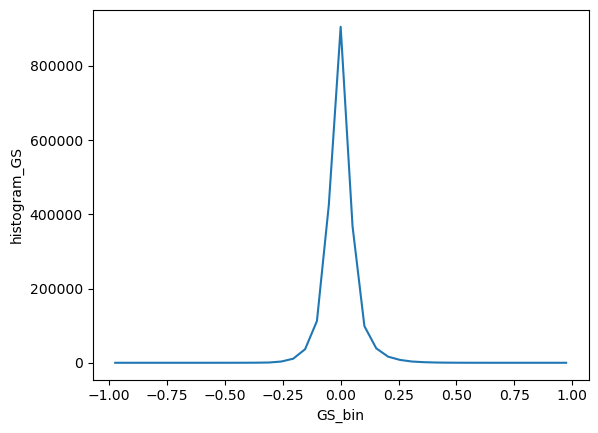

In [27]:
xhist(Ro_GS.isel(Z=18), bins=np.linspace(-1,1,40)).plot()